# Install dependencies

In [1]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install plotly
!pip install scipy
!pip install scikit-learn
!pip install python-dotenv
!pip install openai==0.28.1
!pip install tiktoken

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/02/52/815f643ed3afb3365354548b3c8b557dbf926a65c40ad5b6d9e455147c7e/pandas-2.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached pandas-2.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Obtaining dependency information for numpy<2,>=1.22.4 from https://files.pythonhosted.org/packages/2d/5e/cb38e3d1916cc29880c84a9332a9122a8f49a7b57ec7aea63e0f678587a2/numpy-1.26.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached numpy-1.26.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/32/4d/aaf7eff5deb402fd9a24a1449a8119f00d74ae9c2efa79f8ef9994261fc2/pytz-2023.3.post1-py2.py3-none-any.whl.metadata
  Using cached pytz-2023.3.post1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata

In [2]:
import os
from dotenv import load_dotenv
import openai
import pandas as pd
import tiktoken

# Embedding models

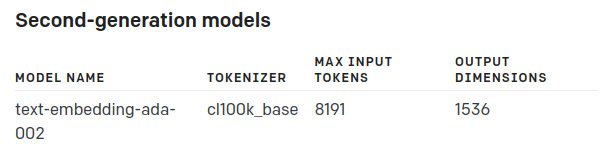

- We are using **text-embedding-ada-002** as embedding model. 
- It outputs **1536 dimensions** vectors.
- It can take a maximun of **8191 tokens**.
- Tokens are obtained with **cl100k_base** tokenizer.

# Get OpenAI API key

In order of using the **text-embedding-ada-002** embedding model from OpenAI we need an API key which can be got in the [OpenAI website](https://openai.com/). I have writen mine in the **.env** file to load it as an environment variable.

In [3]:
load_dotenv()

openai.api_key = os.getenv('OPENAI_API_KEY')
# print(os.getenv('OPENAI_API_KEY'))

# Compute an embedding

In [4]:
def get_embedding(text: str, model: str="text-embedding-ada-002") -> list:
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

In [5]:
embedding = get_embedding('Life is like riding a bicycle. To keep your balance, you must keep moving')

print(f"Dimensions: {len(embedding)}")
embedding[:10]

Dimensions: 1536


[0.007463276386260986,
 -0.012937982566654682,
 0.011391316540539265,
 0.007702641189098358,
 -0.0060056052170693874,
 0.015847187489271164,
 -0.036751724779605865,
 -0.01940697245299816,
 0.009396608918905258,
 -0.025998715311288834]

# Load and prepare data

There are 80 sentences about different topics generated with ChatGPT in he **data** directory.

- 20 sentences about **food** (food.csv)
- 20 sentences about **animals** (animal.csv)
- 20 sentences about **finance** (finance.csv)
- 20 sentences about **sports** (sport.csv)

They were concatenated into a 80 rows DataFrame saved as csv in **data_80.csv** using the function **concat_data**.

In [17]:
def concat_data(dir_path: str='./data') -> pd.DataFrame:
    """Load CSV files from dir_path and concatenate them into a df.

    Args:
        dir_path (str): Path to data.

    Returns
        pd.Dataframe: Concatenated DataFrame.
    """
    df = pd.DataFrame()
    for file_path in os.listdir(dir_path):
        path = os.path.join(dir_path, file_path)
        if os.path.isfile(path) and 'csv' in file_path:
            topic_df = pd.read_csv(path, sep=',')
            df = pd.concat([df, topic_df], ignore_index=True)
    return df

data_80_path = './concatenated_data/data_80.csv'
concat_data().to_csv(data_80_path, index=None)

In [27]:
data_80 = pd.read_csv(data_80_path)
data_80.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  80 non-null     object
 1   label     80 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB


In [28]:
pd.DataFrame(data_80.label.value_counts())

,count
label,
finance,20
animal,20
sport,20
food,20


In [29]:
data_80.head(2)

,sentence,label
0,Budgeting is the key to managing your finances...,finance
1,Investing wisely can help your finances grow o...,finance


In [30]:
data_80.tail(2)

,sentence,label
78,A cheese platter with wine is a great way to u...,food
79,Freshly caught seafood is a specialty of this ...,food


# Check tokenized sentences length

Check length and limit it
https://cookbook.openai.com/examples/get_embeddings_from_dataset

The embedding model only can input a maximun of 8191 tokens every time it receives an input so we should check the length of our sentences before embedding tthem. To check sentences length first we need to tokenize them because the model takes tokens as input. 

We are using the **tiktoken** tokenizer and the **cl100k_base** encoding as recommended in the OpenAI documentation.

In [31]:
def tokenize_string(string: str, encoding_name: str="cl100k_base") -> list[int]:
    """Returns tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    return encoding.encode(string)

In [32]:
# Get token and save in tokens column
data_80['tokens'] = data_80.sentence.apply(lambda x: tokenize_string(x))
data_80.head(3)

,sentence,label,tokens
0,Budgeting is the key to managing your finances...,finance,"[64001, 287, 374, 279, 1401, 311, 18646, 701, ..."
1,Investing wisely can help your finances grow o...,finance,"[34976, 287, 66713, 649, 1520, 701, 40382, 313..."
2,Saving for retirement is a crucial part of fin...,finance,"[44635, 369, 21624, 374, 264, 16996, 961, 315,..."


Now we can compute the tokens length to know if any of them is longer then 8191 tokens.

In [33]:
print(f"Sentences longer than 8191 tokens: {(data_80.tokens.str.len() >= 8191).sum()}") # There is no sentence longer than 8191 tokens
print(f"Mean length: {data_80.tokens.str.len().mean()}")

Sentences longer than 8191 tokens: 0
Mean length: 11.7875


# Get embedding vectors

We will use the get_embedding function provided for OpenAI to get the embeddings.

https://github.com/openai/openai-python/blob/main/openai/embeddings_utils.py

In [34]:
from openai.embeddings_utils import get_embedding

In [35]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # encoding for text-embedding-ada-002
max_tokens = 8000  # maximum for text-embedding-ada-002 is 8191

In [36]:
data_80["embedding"] = data_80.sentence.apply(lambda x: get_embedding(x, engine=embedding_model))
data_80.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   80 non-null     object
 1   label      80 non-null     object
 2   tokens     80 non-null     object
 3   embedding  80 non-null     object
dtypes: object(4)
memory usage: 2.6+ KB


In [37]:
data_80.isna().sum()

sentence     0
label        0
tokens       0
embedding    0
dtype: int64

In [244]:
# Uncomment to save!
# data_80.to_csv('./concatenated_data/data_80_embeddings.csv', index=None)

# PCA

## Reshape embeddings

In [38]:
import numpy as np
import ast

In [39]:
df = pd.read_csv('./concatenated_data/data_80_embeddings.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   80 non-null     object
 1   label      80 non-null     object
 2   tokens     80 non-null     object
 3   embedding  80 non-null     object
dtypes: object(4)
memory usage: 2.6+ KB


In [40]:
df.head(3)

,sentence,label,tokens,embedding
0,Budgeting is the key to managing your finances...,finance,"[64001, 287, 374, 279, 1401, 311, 18646, 701, ...","[-0.0009399246773682535, -0.004582423716783523..."
1,Investing wisely can help your finances grow o...,finance,"[34976, 287, 66713, 649, 1520, 701, 40382, 313...","[0.002446306636556983, -0.01792897842824459, 0..."
2,Saving for retirement is a crucial part of fin...,finance,"[44635, 369, 21624, 374, 264, 16996, 961, 315,...","[0.0072967358864843845, -0.017404714599251747,..."


In [41]:
# The ast.literal_eval() method is a function that evaluates a string as a literal expression, and returns the result
print('Type embedding data point:', type(df.loc[0, 'embedding']))
df['embedding'] = df.embedding.apply(lambda x: ast.literal_eval(x))
print('Type embedding data point:', type(df.loc[0, 'embedding']))

Type embedding data point: <class 'str'>
Type embedding data point: <class 'list'>


In [42]:
print(f"First embedding: \n----------------\n{df.loc[0, 'embedding']}")

First embedding: 
----------------
[-0.0009399246773682535, -0.0045824237167835236, 0.007463514339178801, -0.041899994015693665, -0.01711268350481987, 0.0041601951234042645, -0.014306103810667992, -0.002995961345732212, 0.0015344599960371852, -0.03757835924625397, 0.01748523861169815, 0.01738589070737362, 0.008755037561058998, 0.022167010232806206, -0.023048723116517067, -0.008239669725298882, 0.03136911243200302, -0.027370357885956764, 0.010046560317277908, -0.008500458672642708, -0.02707231417298317, -0.007786395028233528, -0.004967397078871727, -0.01859048381447792, -0.006693567615002394, -0.015287164598703384, 0.012058356776833534, -0.011344293132424355, 0.003616885980591178, -0.016081947833299637, 0.01060539297759533, -0.01420675590634346, 0.011213898658752441, 0.0009538954473100603, -0.008202414028346539, -0.0021732363384217024, 0.009059290401637554, -0.0008110828348435462, 0.016678035259246826, 0.0007466618553735316, 0.03529335558414459, 0.014008060097694397, -0.0002792220329865

In [44]:
embeddings = np.array(df.embedding.tolist())
print('Shape:', embeddings.shape)

Shape: (80, 1536)


In [8]:
embeddings

array([[-0.00093992, -0.00458242,  0.00746351, ...,  0.00943185,
         0.01710027, -0.03939146],
       [ 0.00244631, -0.01792898,  0.01451878, ..., -0.00419912,
         0.0154604 , -0.01935413],
       [ 0.00729674, -0.01740471,  0.00736545, ..., -0.00180857,
         0.01120124, -0.02683799],
       ...,
       [ 0.01745596,  0.01310805,  0.02384919, ..., -0.00975707,
        -0.00753166, -0.0146131 ],
       [ 0.01612055, -0.00741286,  0.02745026, ...,  0.00925799,
         0.00030307, -0.02451101],
       [ 0.02075868, -0.00062537,  0.02568625, ..., -0.0075093 ,
        -0.01985442, -0.00650675]])

In [9]:
print('Number of embeddings :', len(embeddings))
print('Embedding length     :', len(embeddings[0]))

Number of embeddings : 80
Embedding length     : 1536


## Reduce data dimensionality using PCA

In [10]:
from sklearn.decomposition import PCA

### 1536 dimensions -> 2 dimensions

In [11]:
two_dim_embeddings = PCA(random_state=0, n_components=2).fit_transform(embeddings) #[:,:3]
print('Shape:', two_dim_embeddings.shape)
two_dim_embeddings[:5]

Shape: (80, 2)


array([[0.34112927, 0.04398543],
       [0.33263518, 0.04194145],
       [0.29035947, 0.02548013],
       [0.22687835, 0.00484066],
       [0.25547223, 0.04220011]])

### 1536 dimensions -> 3 dimensions

In [12]:
three_dim_embeddings = PCA(random_state=0, n_components=3).fit_transform(embeddings) #[:,:3]
print('Shape:', two_dim_embeddings.shape)
three_dim_embeddings[:5]

Shape: (80, 2)


array([[ 0.34112928,  0.04398394, -0.01940915],
       [ 0.33263523,  0.0419402 , -0.05582152],
       [ 0.29035949,  0.02547859, -0.02792763],
       [ 0.22687829,  0.0048433 , -0.04793241],
       [ 0.25547217,  0.04220381, -0.06980333]])

### Save reduced embeddings

In [13]:
df["PCA_2D"] = list(map(lambda x: list(x), two_dim_embeddings))
df["PCA_3D"] = list(map(lambda x: list(x), three_dim_embeddings))
df.head(2)

,sentence,label,tokens,embedding,PCA_2D,PCA_3D
0,Budgeting is the key to managing your finances...,finance,"[64001, 287, 374, 279, 1401, 311, 18646, 701, ...","[-0.0009399246773682535, -0.004582423716783523...","[0.34112926783458464, 0.043985433147298976]","[0.34112927553076006, 0.04398393936576726, -0...."
1,Investing wisely can help your finances grow o...,finance,"[34976, 287, 66713, 649, 1520, 701, 40382, 313...","[0.002446306636556983, -0.01792897842824459, 0...","[0.33263518043048884, 0.04194145013825972]","[0.3326352264121871, 0.04194019985135301, -0.0..."


In [14]:
# df.to_csv('./concatenated_data/data_80_embeddings_PCA.csv', index=None)

# Visualizations

Each sentence is mapped into embedding space with is vector representation.

https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c

https://towardsdatascience.com/visualizing-word-embedding-with-pca-and-t-sne-961a692509f5

In [17]:
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

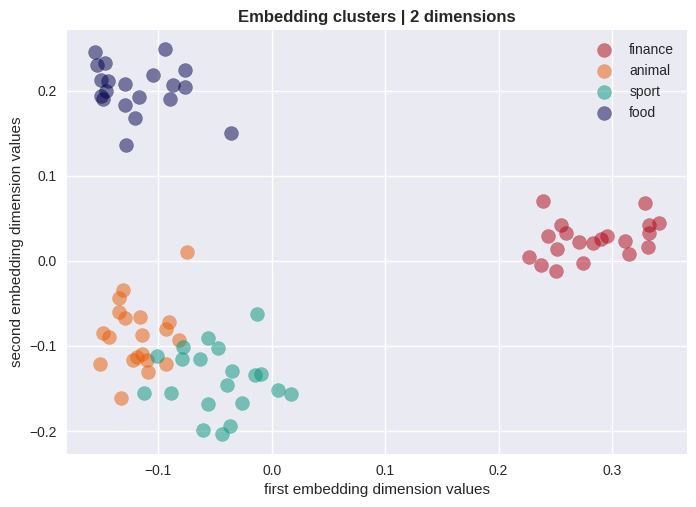

In [47]:
def plot_2D_plt(points: np.ndarray) -> None:
    
    plt.style.use('seaborn-v0_8')
    
    fig, ax = plt.subplots()
    
    x = points[:20].T[0]
    y = points[:20].T[1]
    ax.scatter(x, y, color = '#b00412', alpha=0.5, s=100, label='finance')

    x = points[20:40].T[0]
    y = points[20:40].T[1]
    ax.scatter(x, y, color = '#e85a02', alpha=0.5, s=100, label='animal')
    
    x = points[40:60].T[0]
    y = points[40:60].T[1]
    ax.scatter(x, y, color = '#00947b', alpha=0.5, s=100, label='sport')
    
    x = points[60:80].T[0]
    y = points[60:80].T[1]
    ax.scatter(x, y, color = '#00004d', alpha=0.5, s=100, label='food')
    
    ax.set_title('Embedding clusters | 2 dimensions', fontweight ="bold")
    ax.set_xlabel('first embedding dimension values')
    ax.set_ylabel('second embedding dimension values')
    leg = ax.legend();
    
    plt.show()

plot_2D_plt(two_dim_embeddings)

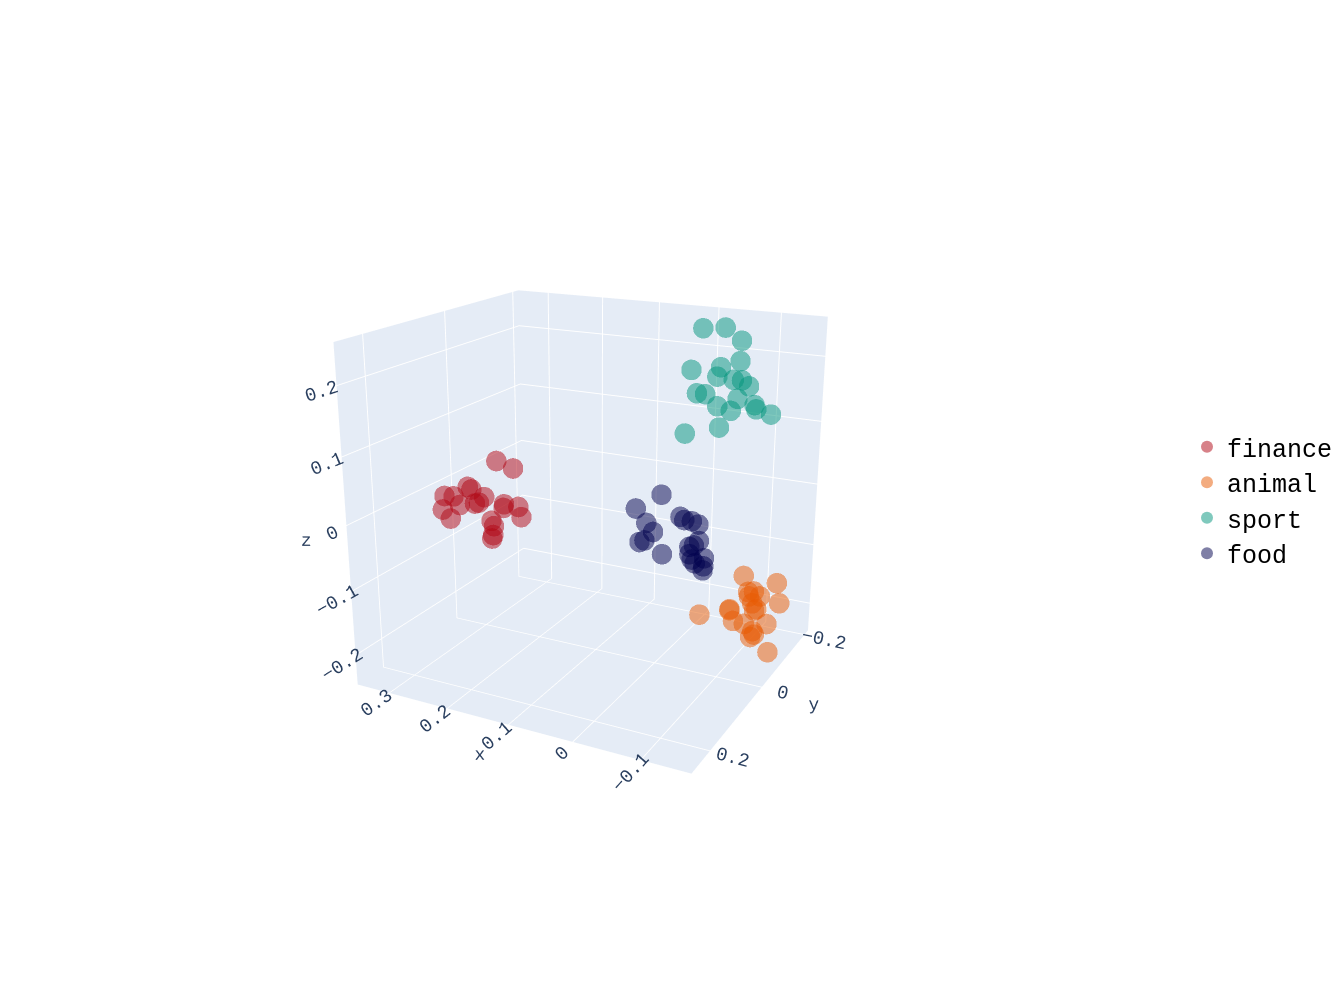

In [204]:
trace1 = go.Scatter3d(
    x=three_dim_embeddings[:20].T[0], 
    y=three_dim_embeddings[:20].T[1], 
    z=three_dim_embeddings[:20].T[2],
    name='finance',
    mode='markers',
    marker=dict(
        size=12,
        color='#b00412',
        opacity=0.5)
)
trace2 = go.Scatter3d(
    x=three_dim_embeddings[20:40].T[0], 
    y=three_dim_embeddings[20:40].T[1], 
    z=three_dim_embeddings[20:40].T[2],
    name='animal',
    mode='markers',
    marker=dict(
        size=12,
        color='#e85a02',
        opacity=0.5)
    
)
trace3 = go.Scatter3d(
    x=three_dim_embeddings[40:60].T[0], 
    y=three_dim_embeddings[40:60].T[1], 
    z=three_dim_embeddings[40:60].T[2],
    name='sport',
    mode='markers',
    marker=dict(
        size=12,
        color='#00947b',
        opacity=0.5)
)
trace4 = go.Scatter3d(
    x=three_dim_embeddings[60:80].T[0], 
    y=three_dim_embeddings[60:80].T[1], 
    z=three_dim_embeddings[60:80].T[2],
    name='food',
    mode='markers',
    marker=dict(
        size=12,
        color='#00004d',
        opacity=0.5)
)
data = [trace1, trace2, trace3, trace4]
 
layout = go.Layout(
    margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
    showlegend = True,
    legend = dict(
        x = 1,
        y = 0.5,
        font = dict(
            family = "Courier New",
            size = 25,
            color = "black")),
    font = dict(
        family = " Courier New ",
        size = 15),
    autosize = False,
    width = 1000,
    height = 1000
)

fig = go.Figure(data=data, layout=layout)

fig.show()

# Visualize the embeddings high dimensional

In [15]:
ten_dim_embeddings = PCA(random_state=0, n_components=10).fit_transform(embeddings)
print('Shape:', ten_dim_embeddings.shape)
ten_dim_embeddings[:5]

Shape: (80, 10)


array([[ 0.34112917,  0.04396972, -0.0193556 , -0.04074227, -0.03811587,
         0.02461987,  0.05830539, -0.04123463,  0.00687762,  0.03061564],
       [ 0.33263473,  0.04194819, -0.05583184,  0.02477013, -0.03857199,
        -0.00175309, -0.01167556,  0.07384704, -0.07085543, -0.02237246],
       [ 0.29036067,  0.0255196 , -0.02792706, -0.02195358,  0.02820292,
        -0.01586628, -0.00661595,  0.04922789, -0.01460439, -0.01622239],
       [ 0.22687634,  0.00476349, -0.04789546,  0.00482084,  0.05537189,
         0.03436429,  0.00097942, -0.04733679,  0.0865835 , -0.0084341 ],
       [ 0.25547435,  0.04219393, -0.06976832, -0.01800144,  0.08928028,
        -0.06522512, -0.08492821,  0.04396356,  0.01309711,  0.04502273]])

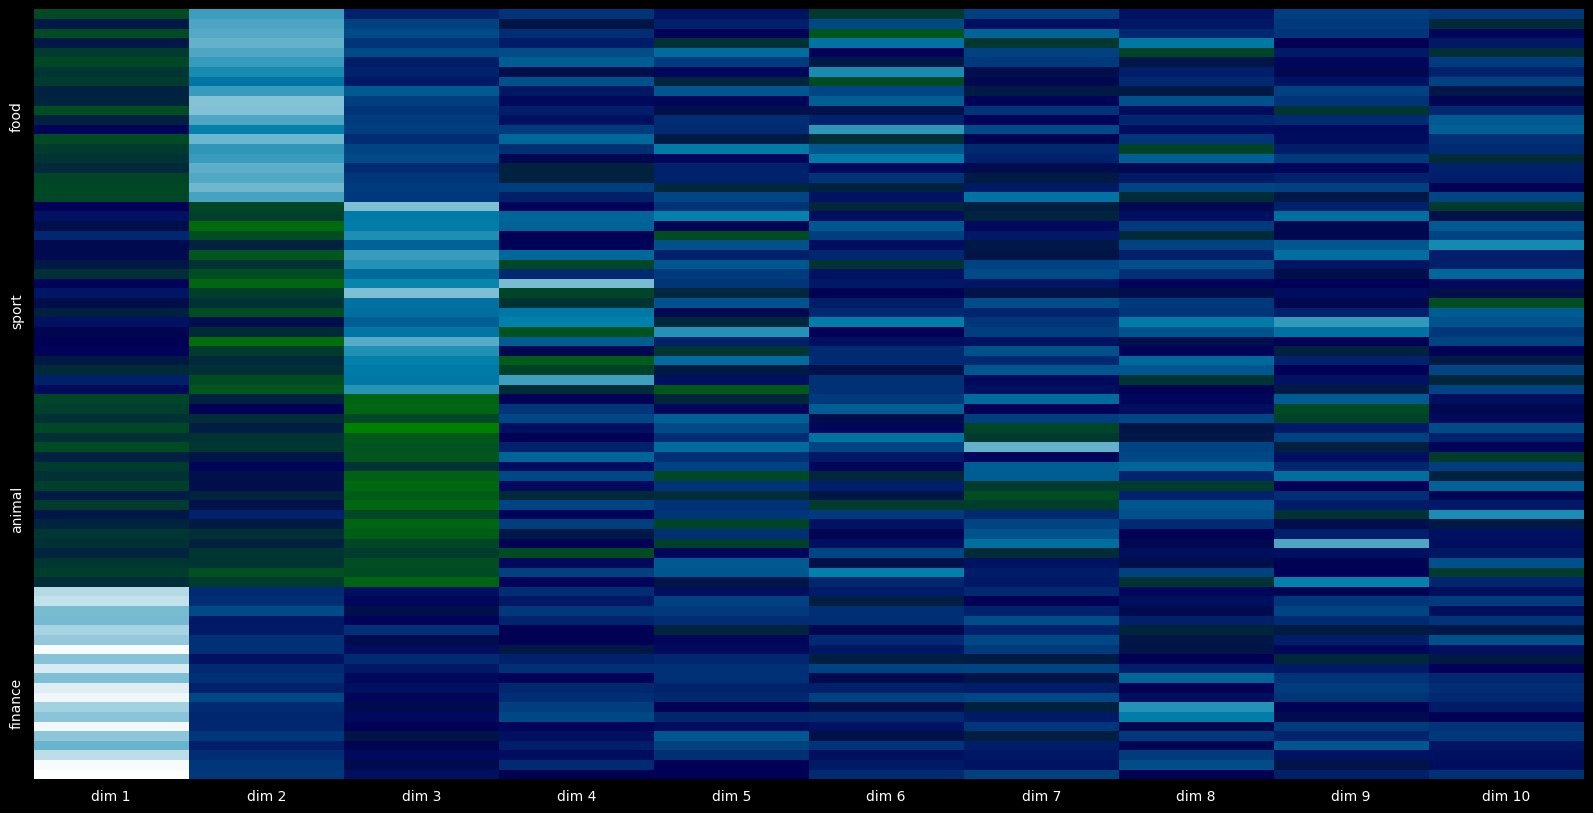

In [44]:
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(20, 10))
ax.pcolormesh(ten_dim_embeddings, cmap='ocean')
#ax.set_frame_on(True) # remove all spines
# ax.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# ax.set_yticklabels([])
ax.set_xticks([.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], labels=['dim 1', 'dim 2', 'dim 3', 'dim 4', 'dim 5', 'dim 6', 'dim 7', 'dim 8', 'dim 9', 'dim 10'])
ax.set_yticks([10, 30, 50, 70], labels=['finance', 'animal', 'sport', 'food'], rotation=90)

ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
ax.tick_params(bottom = False, left = False)

# ax.set_title('Embedding vectors visualization | 10 dimensions', fontweight ="bold")
plt.show()